In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
#!pip install transformers

In [ ]:
# connect google drive for easy dataset imports
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Exploratory Data Analysis

In [ ]:
# enable direct upload if necessary
from google.colab import files
uploaded = files.upload()

Saving model data.csv to model data.csv


In [ ]:
# take a look at the head of the data
df = pd.read_csv("model data.csv")
df.head()

,Text,Sentiment,Length
0,"According to Gran , the company has no plans t...",neutral,127
1,With the new production plant the company woul...,positive,206
2,"For the last quarter of 2010 , Componenta 's n...",positive,193
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,122
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,103


In [ ]:
# explore the raw dataset dimensions
df.shape

(99706, 3)

In [ ]:
# check for null entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99706 entries, 0 to 99705
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       99706 non-null  object
 1   Sentiment  99706 non-null  object
 2   Length     99706 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


In [ ]:
class EDA:
    """
    Performs EDA on a specified dataset.
    """
    def __init__(self, dataset):
        """
        dataset (Pandas DataFrame):
            dataset of interest
        """
        self.data = pd.read_csv(dataset)
        
    def plot_stats(self):
        """
        Outputs 2 plots:
            1. Histogram of text sentiments (3 types).
            2. Distribution of text lengths for every sentiment.
        """
        # histogram of text sentiments (3 types)
        sns.countplot(x = "Sentiment", data=self.data)
        plt.xlabel("Sentiment", size=15)
        plt.ylabel("Count", size=15)
        plt.title("Count of all tweet sentiments", size=17)
        plt.show()
        
        # distributions of text lengths for every sentiment
        grid = sns.FacetGrid(self.data, col = "Sentiment")
        grid.map(plt.hist, "Length")
        plt.show()
        
    def clean(self, method):
        """
        Cleans the dataset.
        -----------------------------
        method (str):
            sentiment analysis method
        """
        cleaned = []
        labels = []
        for text in self.data["Text"]:
            # remove unnecessary characters that do not impact the outcome
            # remove @ tags and links from the text
            text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])" \
                                  "|(\w+:\/\/\S+)", " ", text).split()) 
            # convert all letters to lower case and replacing '-' with spaces.
            text = text.lower().replace('-', ' ')
            # remove stopwords and numbers
            table = str.maketrans('', '', string.punctuation+string.digits)
            text = text.translate(table)
            if method == "rule-based":
                # tokenize words 
                tokens = word_tokenize(text)
                # stem the words 
                stemmed = [porter.stem(word) for word in tokens]
                words = [w for w in stemmed if not w in n_words]
                text = ' '.join(words)
            cleaned.append(text)
        self.data["Text"] = np.array(cleaned)

In [ ]:
data_path = "model data.csv"
data = EDA(data_path)
data.clean(method="transformer")

In [ ]:
# explore the cleaned data
bert_data = data.data
bert_data.head()

,Text,Sentiment,Length
0,according to gran the company has no plans to ...,neutral,127
1,with the new production plant the company woul...,positive,206
2,for the last quarter of componenta s net sale...,positive,193
3,operating profit rose to eur mn from eur m...,positive,122
4,operating profit totalled eur mn up from eur...,positive,103


## Data Preprocessing

In [ ]:
def to_sentiment(sentiment):
    """
    Turns sentiment into an arbitrary label (0, 1, 2)
    ----------------
    sentiment (str):
        text sentiment (neutral, positive, negative)
    """
    if sentiment == "neutral":
        return 0
    elif sentiment == "positive":
        return 1
    else:
        return 2
bert_data['Label'] = bert_data["Sentiment"].apply(to_sentiment)
class_names = ['neutral', 'positive', 'negative']

In [ ]:
# initialize BERT tokenizer and BERT model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                                do_lower_case=True, 
                                                num_labels = 3)
bert_model = BertModel.from_pretrained('bert-base-uncased', num_labels = 3)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# find the token length of each review to determine max length 
# (will be utilized later during tokenization)
tokens_arr = []
for txt in bert_data["Text"]:
    tokens = bert_tokenizer.encode(txt, max_length=500)
    tokens_arr.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


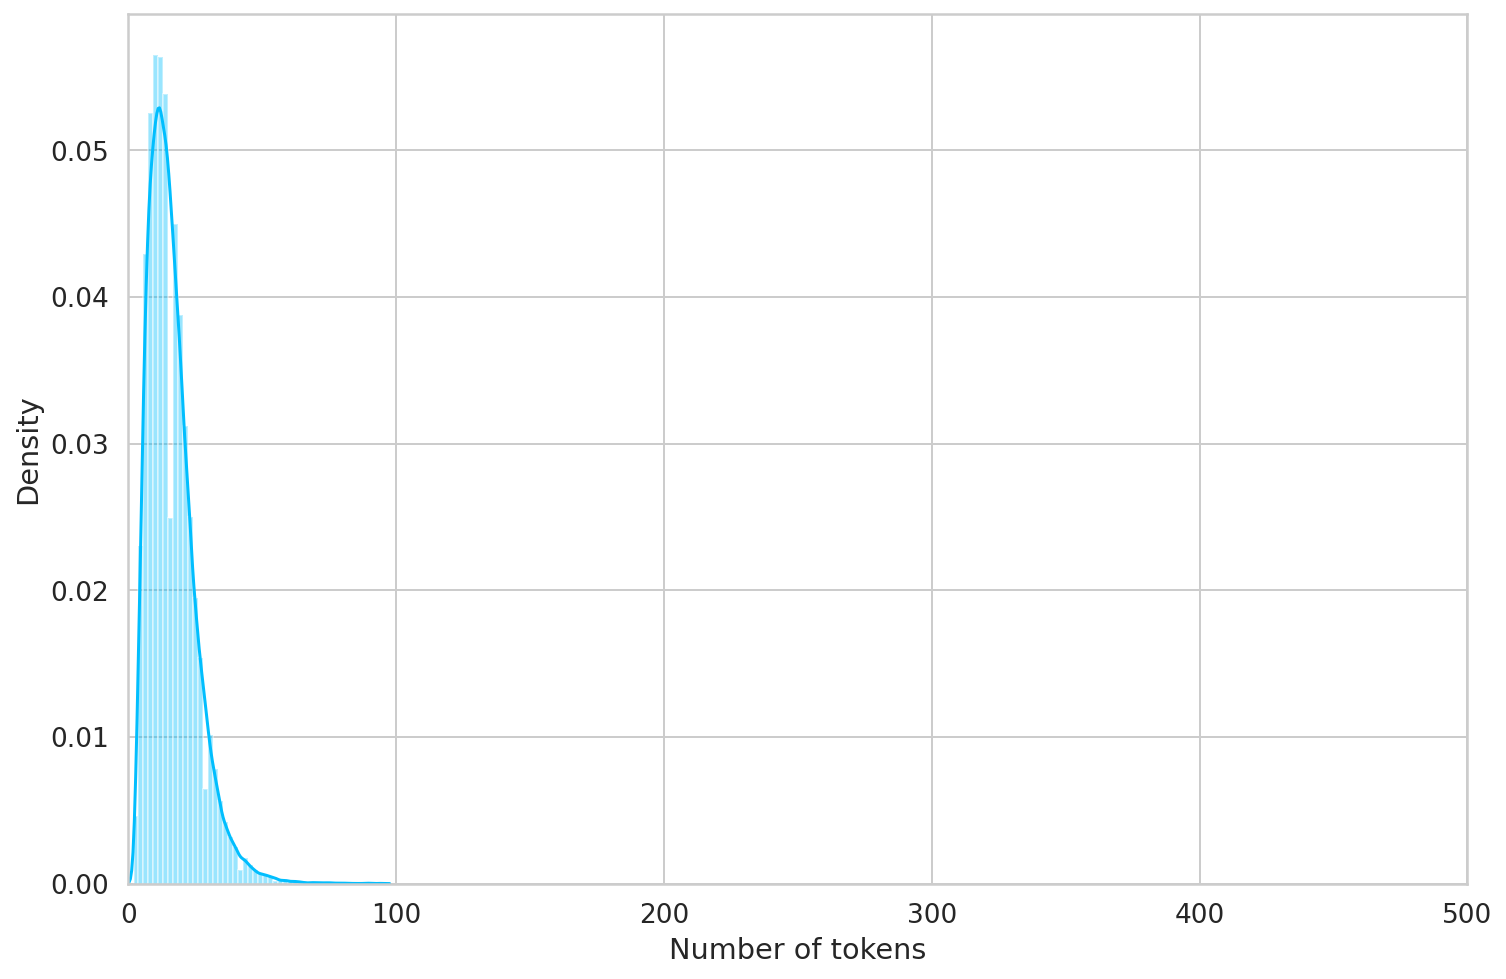

In [ ]:
sns.distplot(tokens_arr)
plt.xlim([0, 500]);
plt.xlabel('Number of tokens')
plt.show()

In [ ]:
MAX_LEN = 100

class GPReviewDataset(Dataset):
    """
    Creates a dataset of tokenized entries in a format suitable for BERT model.
    """
    def __init__(self, reviews, targets, tokenizer, max_len):
        """
        reviews (Pandas DataFrame):
            compiled dataset reviews
        targets (Pandas DataFrame):
            outcome variable (pre-labeled sentiment)
        tokenizer (BertTokenizer object):
            tokenizer that turns text input into a machine-friendly form
        max_len (int):
            maximum length of a tokenized sequence
        
        """
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        """
        Returns the size of the input column.
        """
        return len(self.reviews)

    def __getitem__(self, item):
        """
        Compiles input, output, and encoded data together.
        -------------------
        Returns:
            a dictionary containing the objects specified above.
        """
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(review,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_tensors='pt')
        
        return {'review_text': review,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

In [ ]:
# split the data into train, validation, test sets (90%, 5%, 5% respectively)
df_train, df_test = train_test_split(bert_data,
                                     test_size=0.1,
                                     random_state=RANDOM_SEED, 
                                     stratify=bert_data["Label"])

df_val, df_test = train_test_split(df_test,
                                   test_size=0.5,
                                   random_state=RANDOM_SEED,
                                   stratify=df_test["Label"])
df_train.shape, df_val.shape, df_test.shape

((89735, 4), (4985, 4), (4986, 4))

In [ ]:
BATCH_SIZE = 16
def create_data_loader(df, tokenizer, max_len, batch_size):
    """
    Creates DataLoader objects for train/validation/test sets.
    ---------------------------------
    tokenizer (BertTokenizer object):
        tokenizer that turns text input into a machine-friendly form
    max_len (int):
        maximum length of a tokenized sequence
    batch_size (int):
        the number of training examples utilized in one iteration
    """
    ds = GPReviewDataset(reviews=df["Text"].to_numpy(),
                         targets=df["Label"].to_numpy(),
                         tokenizer=bert_tokenizer,
                         max_len=max_len)
    
    return DataLoader(ds, batch_size=batch_size,num_workers=4)

In [ ]:
train_data_loader = create_data_loader(df_train, bert_tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, bert_tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, bert_tokenizer, MAX_LEN, BATCH_SIZE)

## Sentiment Classification

In [ ]:
class SentimentClassifier(nn.Module):
    """
    Creates Bert model architecture.
    """
    def __init__(self, n_classes):
        """
        bert (BertModel object):
            BERT model
        drop (nn.Dropout object):
            percentage of neurons that are removed in every layer for regularization
        out (nn.Linear object):
            defines the output format based on the number of classes (3)
        
        """
        super(SentimentClassifier, self).__init__()
        self.bert = bert_model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        """
        Runs through model architecture layer-by-layer.
        ------------------------------
        input_ids (arr):
            list of tokens that represent words
        attention_mask (arr):
            a combination of 0s (pad tokens) and 1 (real tokens)
        """
        _, pooled_output = self.bert(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     return_dict=False)
        
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
# initialize the model
model = SentimentClassifier(len(class_names))
model = model.to(device)

### Training

In [ ]:
# number of training iterations
EPOCHS = 5
# Adam algorithm with weight decay fix
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)
# penalizes the outcome probability based on how far it is from the actual expected value
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    """
    Performs training of 1 epoch.
    ---------------------------------
    model (BertModel object):
        bert model
    data_loader (DataLoader object)
        train/validation set data loader
    loss_fn (CrossEntropyLoss object):
        loss function
    optimizer (AdamW object):
        model optimizer
    device (cuda object):
        GPU
    scheduler:
        helps start model training
    n_examples: 
        dataset size
    --------------------------------
    Returns:
        model accuracy, mean model loss
    """
    model = model.train()

    losses = []
    correct_predictions = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    """
      Evaluates model performance.
      ---------------------------------
      model (BertModel object):
          bert model
      data_loader (DataLoader object)
          train/validation set data loader
      loss_fn (CrossEntropyLoss object):
          loss function
      device (cuda object):
          GPU
      n_examples: 
          dataset size
      --------------------------------
      Returns:
          model accuracy, mean model loss
      """

    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

# place to store training history
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 5)
    # train the epoch
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, 
                                        optimizer, device, scheduler, len(df_train))

    print(f'Train loss {train_loss} accuracy {train_acc}')
    # evaluate the epoch
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    # save training/validation history
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # update validation accuracy if necessary
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        
        best_accuracy = val_acc

Epoch 1/5
-----
Train loss 0.6197010523153618 accuracy 0.7444698278263777
Val   loss 0.5756986470272144 accuracy 0.7695085255767301

Epoch 2/5
-----
Train loss 0.4174117635810018 accuracy 0.8406084582381457
Val   loss 0.682937998814174 accuracy 0.7648946840521564

Epoch 3/5
-----
Train loss 0.2778523456237438 accuracy 0.905466094611913
Val   loss 0.8754367106474745 accuracy 0.7669007021063189

Epoch 4/5
-----
Train loss 0.1991278026719352 accuracy 0.9418732935866719
Val   loss 1.0722409730705504 accuracy 0.7658976930792377

Epoch 5/5
-----
Train loss 0.1489140024741257 accuracy 0.9594472613807322
Val   loss 1.2674529203512253 accuracy 0.7681043129388164

CPU times: user 1h 34min 19s, sys: 38min 20s, total: 2h 12min 40s
Wall time: 2h 13min 10s


Note that we're storing the state of the best model, indicated by the highest validation accuracy.

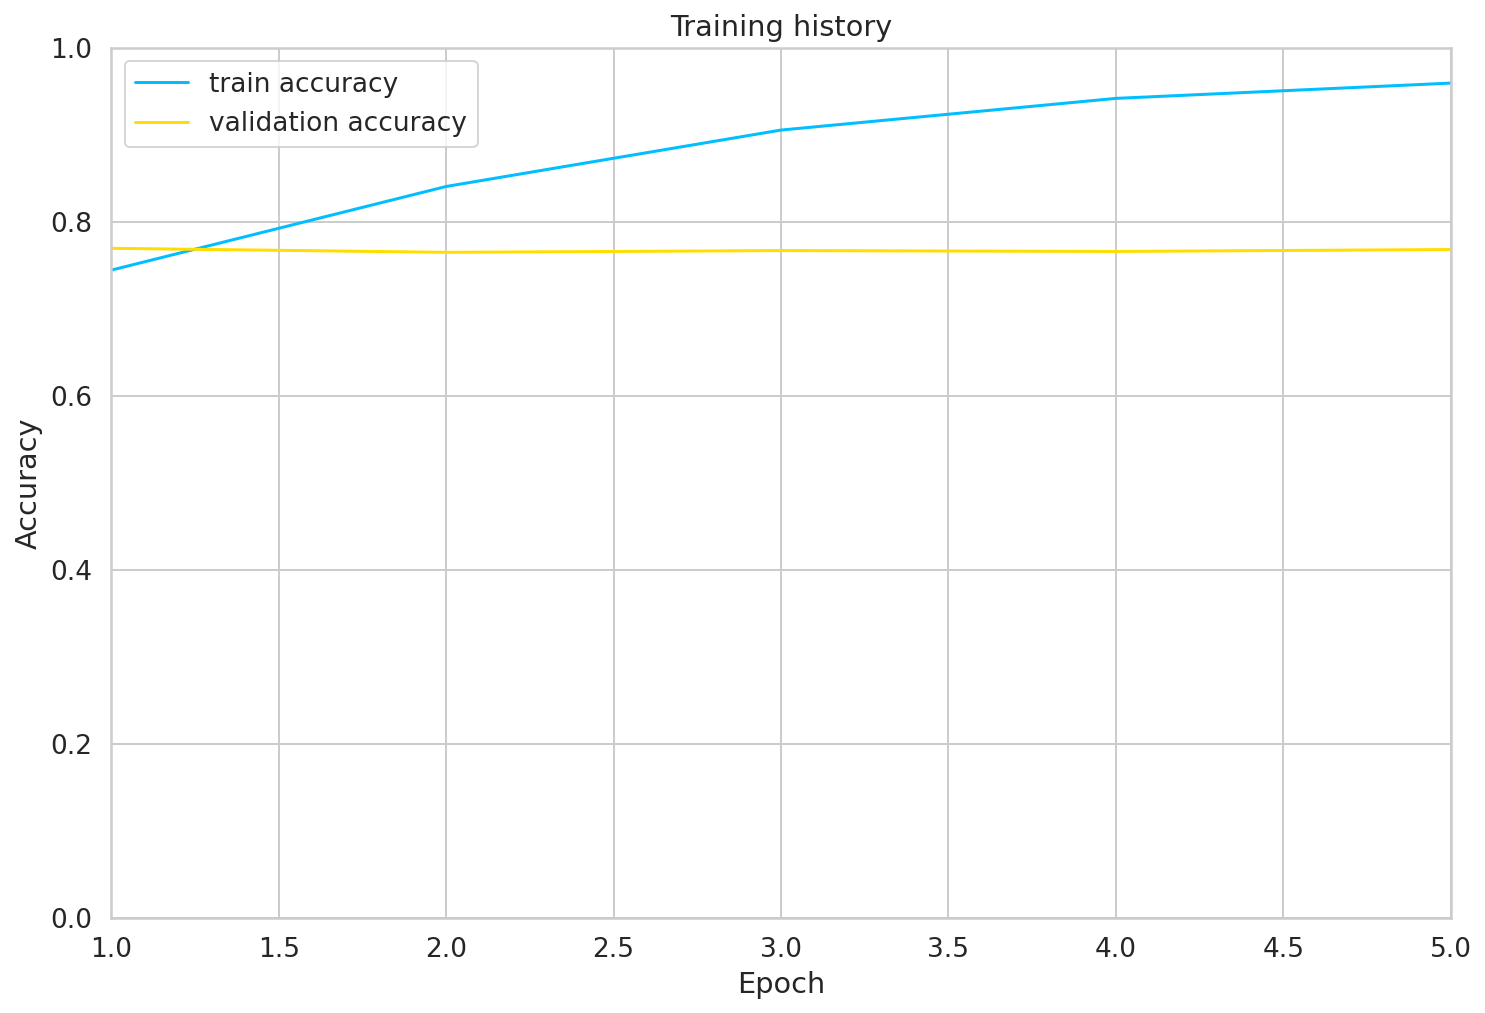

In [ ]:
train_acc = torch.FloatTensor(history["train_acc"])
val_acc = torch.FloatTensor(history["val_acc"])

plt.plot(list(range(1, len(train_acc)+1)),train_acc, label='train accuracy')
plt.plot(list(range(1, len(val_acc)+1)), val_acc, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.xlim([1, 5])
plt.legend()
plt.show()


In [ ]:
torch.save(model.state_dict(), 'best_bert_model.bin')
files.download('best_bert_model.bin')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In case there is no time to train the transformer model, please uncomment the code cell below. The code uses best model state to restore the weights and get the model ready for predictions.

In [ ]:
class_names = ['neutral', 'positive', 'negative']
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/best_bert_model.bin'))
model = model.to(device)

## Evaluation

In [ ]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

print(f"Accuracy on the test set: {round(test_acc.item(), 4)*100}%")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy on the test set: 78.34%


The accuracy is about 2% higher on the test set compared to the validation set. This signals that the model is able to generalize.

In [ ]:
def get_predictions(model, data_loader):
    """
    Outputs predicted sentiment labels.
    --------------------
    model (BertModel object):
          bert model
    data_loader (DataLoader object)
        train/validation set data loader
    --------------------
    Returns:
        initial text (arr), predictions (arr), 
        prediction probabilities (arr), initial target values (arr)
    """
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [ ]:
# store the text of the reviews and the predicted probabilities
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     neutral       0.82      0.83      0.83      2491
    positive       0.76      0.76      0.76      1470
    negative       0.72      0.70      0.71      1025

    accuracy                           0.78      4986
   macro avg       0.77      0.76      0.77      4986
weighted avg       0.78      0.78      0.78      4986



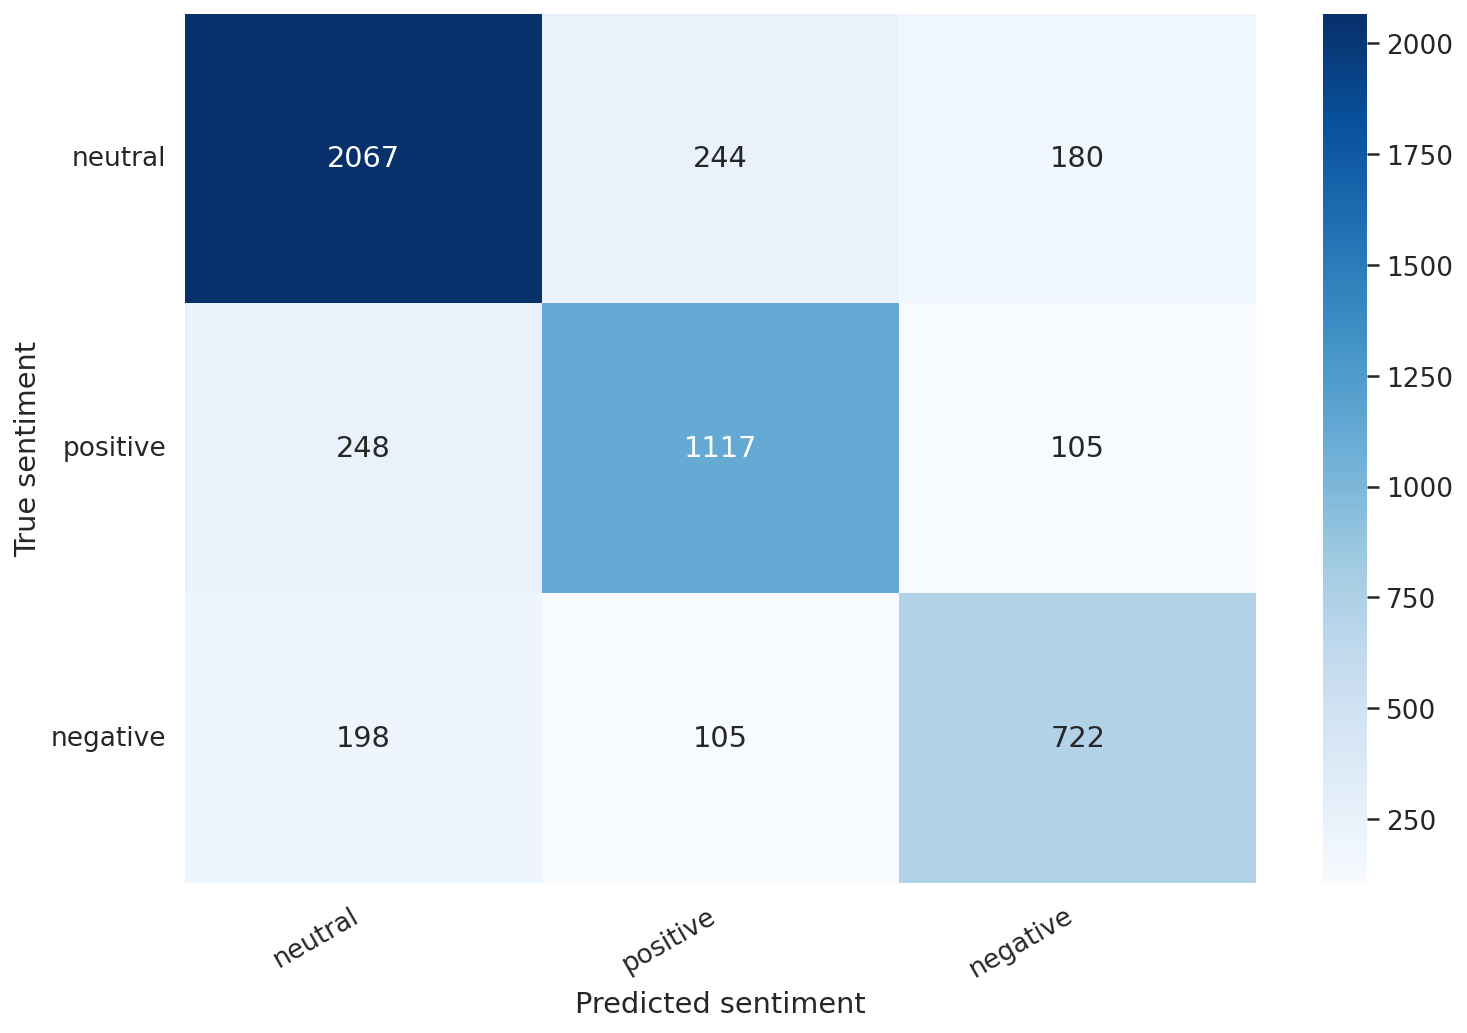

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## Predicting the Sentiment on a Real Dataset of Bitcoin Tweets

In [ ]:
uploaded_tweets = files.upload()

Saving btc_tweets.csv to btc_tweets.csv


In [ ]:
uploaded_prices = files.upload()

Saving btc_prices.csv to btc_prices.csv


In [ ]:
btc_tweets = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/btc_tweets.csv")

In [ ]:
btc_prices = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/btc_prices.csv")

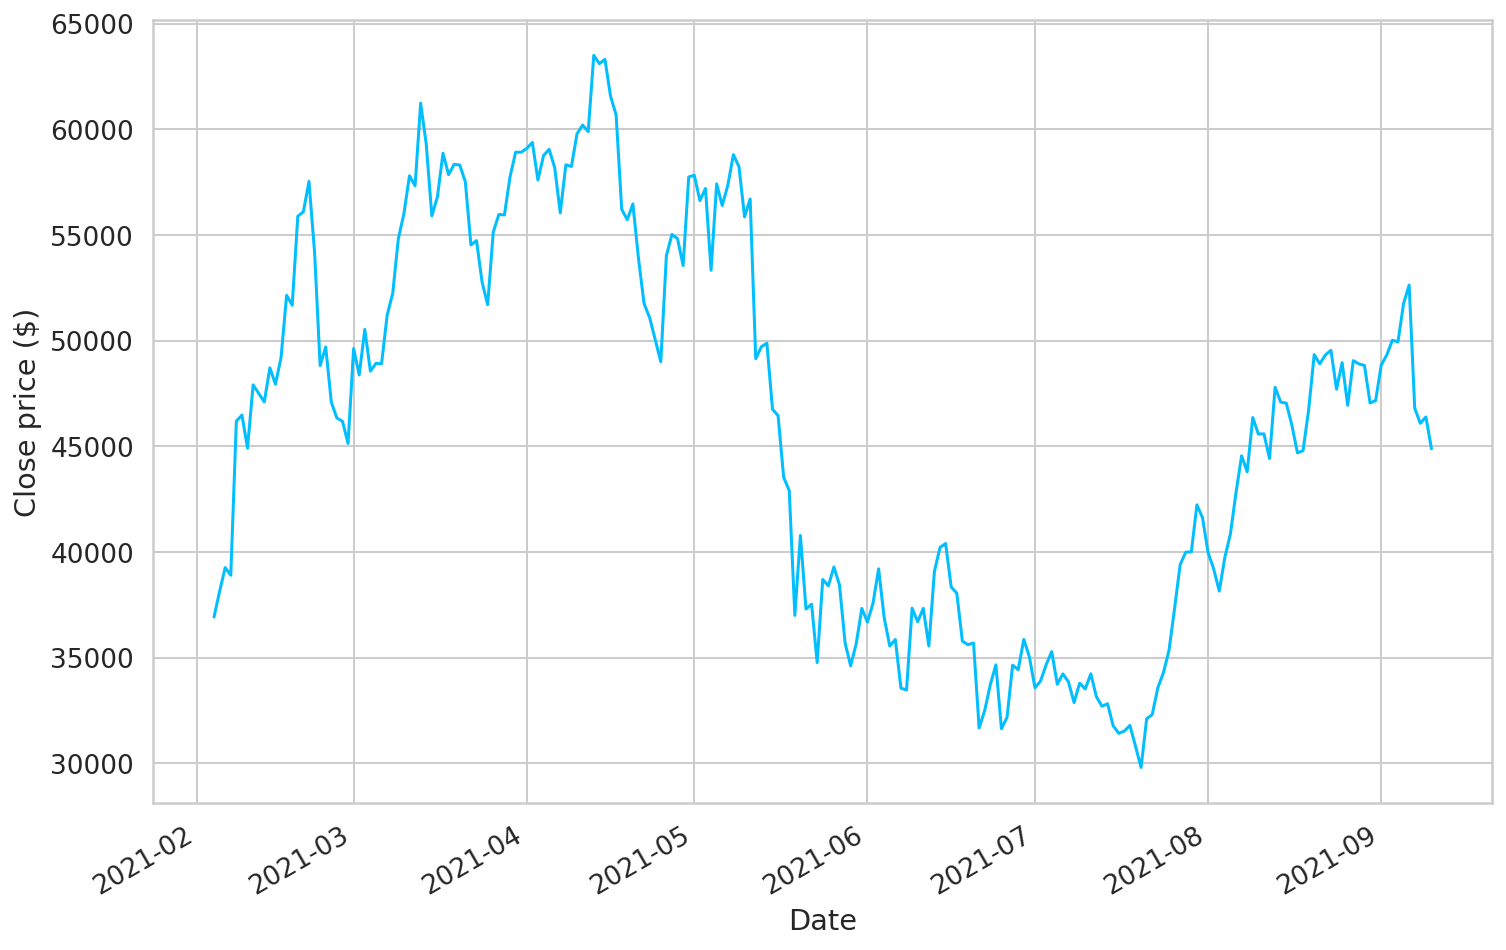

In [ ]:
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(btc_prices["Date"]), btc_prices["Close"])
# Rotate and align the tick labels so they look better.
fig.autofmt_xdate()
# Use a more precise date string for the x axis locations in the toolbar.
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.xlabel("Date")
plt.ylabel("Close price ($)")
plt.show()

In [ ]:
btc_tweets.drop("Unnamed: 0", axis=1, inplace=True)
btc_prices.drop("Unnamed: 0", axis=1, inplace=True)

In [ ]:
def classify_sentiment():
    """
    Outputs the sentiment of Bitcoin tweet data (similar to get_predictions())
    """
    sentiments = []
    for tweet in btc_tweets["text"]:
        encoded_review = bert_tokenizer.encode_plus(tweet, max_length=100,
                                                    add_special_tokens=True,
                                                    return_token_type_ids=False,
                                                    pad_to_max_length=True,
                                                    return_attention_mask=True,
                                                    return_tensors='pt')
        input_ids = encoded_review['input_ids'].to(device)
        attention_mask = encoded_review['attention_mask'].to(device)

        result = model(input_ids, attention_mask)
        _, prediction = torch.max(result, dim=1)
        if class_names[prediction] == "positive":
            sentiments.append(1)
        elif class_names[prediction] == "neutral":
            sentiments.append(0)
        else:
            sentiments.append(-1)

    return np.array(sentiments)

In [ ]:
btc_tweets.dropna(inplace=True)


In [ ]:
# add a column of newly classified sentiment to BTC tweet dataset
btc_tweets["Sentiment"] = classify_sentiment()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
#btc_tweets.head()

,date,text,Sentiment
0,2021-02-05 10:52:04,debunking bitcoin myths by lowry cryptocurre...,0
1,2021-02-05 10:52:04,weekend read keen to learn about crypto assets...,0
2,2021-02-05 10:52:06,bloomberg lp cryptooutlook with cryptocurren...,0
3,2021-02-05 10:52:07,blockchain by cryptocurrency bitcoin crypto...,0
4,2021-02-05 10:52:26,reddcoin rdd to the moon altcoin turnreddcoini...,0


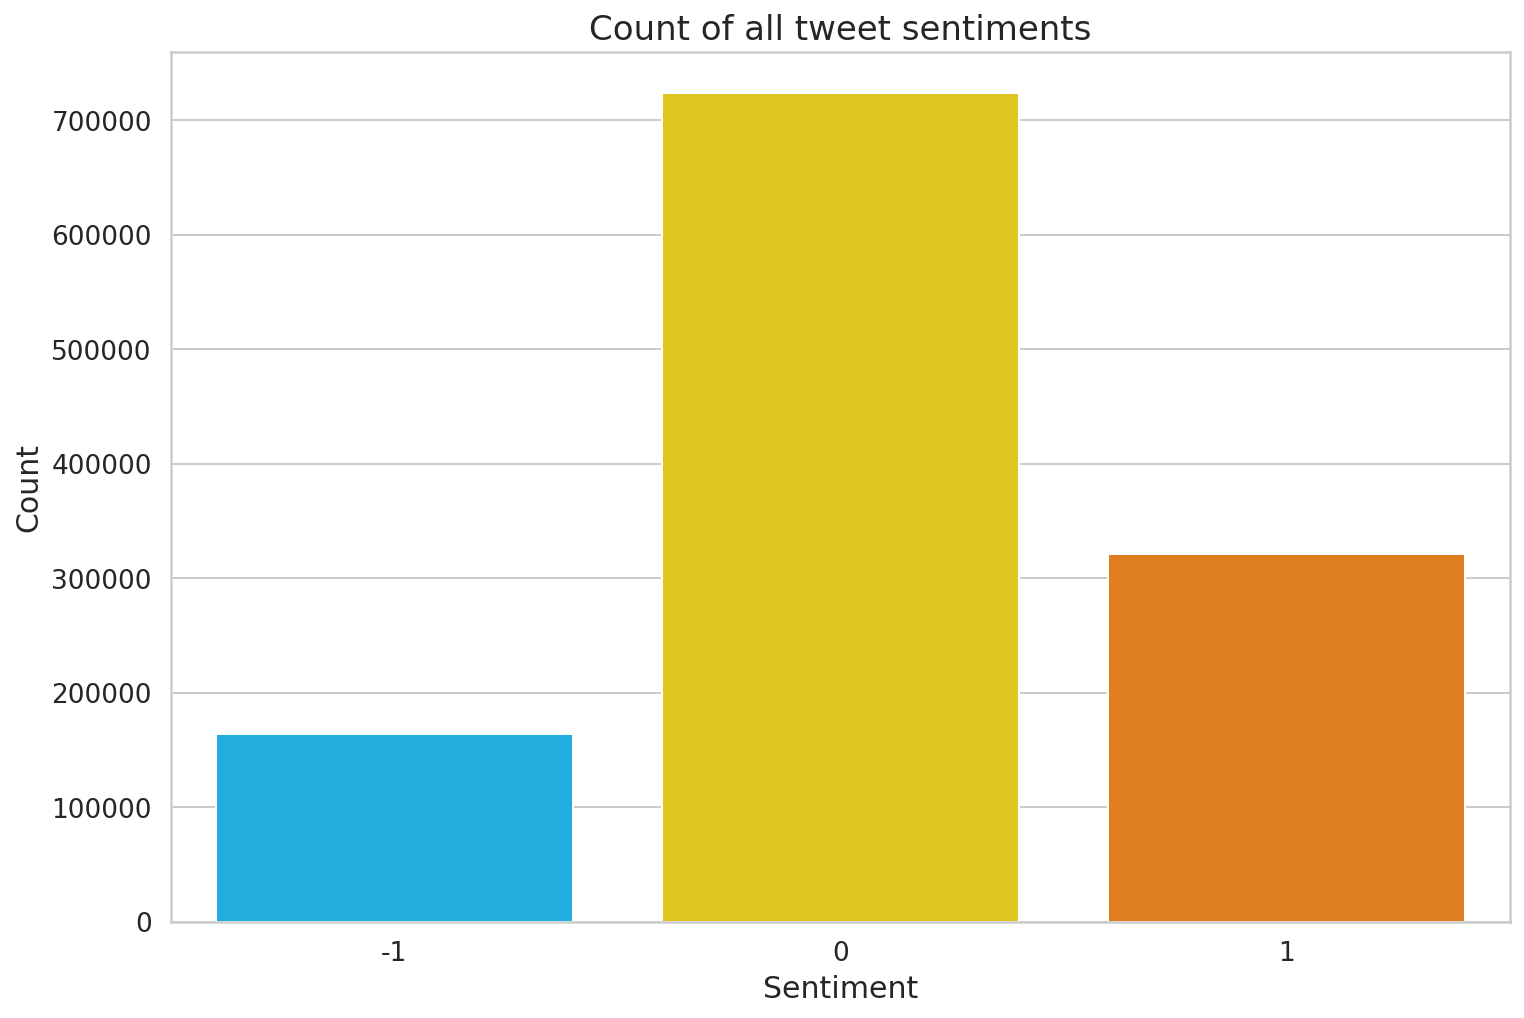

In [ ]:
sns.countplot(x = "Sentiment", data=btc_tweets)
plt.xlabel("Sentiment", size=15)
plt.ylabel("Count", size=15)
plt.title("Count of all tweet sentiments", size=17)
plt.show()

In [ ]:
btc_tweets.to_csv("btc_tweets_sentiment.csv")

In [ ]:
from google.colab import files

In [ ]:
files.download("btc_tweets_sentiment.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
btc_tweets_pos_neg = btc_tweets.copy()

In [ ]:
# remove the neutral tweets from the dataset as they do not
# contribute to bitcoin fluctuations according to our research design
btc_tweets_pos_neg.drop(btc_tweets_pos_neg.loc[btc_tweets_pos_neg['Sentiment']==0].index, inplace=True)
print(f"Dataset size without neutral tweets: {btc_tweets_pos_neg.shape[0]} rows, " \
      f"{btc_tweets_pos_neg.shape[1]} columns")


Dataset size without neutral tweets: 485616 rows, 3 columns


In [ ]:
btc_tweets_pos_neg.to_csv("btc_tweets_pos_neg.csv")

In [ ]:
files.download("btc_tweets_pos_neg.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
btc_tweets_pos_neg = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/btc_tweets_pos_neg.csv")

In [ ]:
btc_tweets_pos_neg["date"] = pd.to_datetime(btc_tweets_pos_neg["date"]).dt.date


In [ ]:
# group entries by date and take the mean sentiment score for each day
btc_tweets_lagged1 = btc_tweets_pos_neg.groupby("date", as_index=False)["Sentiment"].mean()

In [ ]:
btc_tweets_lagged1.index = np.arange(1, len(btc_tweets_lagged1)+1)
btc_prices.index = np.arange(1, len(btc_prices)+1)

In [ ]:
def add_btc_prices(lag):
    """
    Adds BTC prices (current and lagged) to the BTC tweet dataset.
    ------------------------
    lag (int):
        data lag (in days)
    """
    close_prices = []
    prices_lagged_1day = []
    for d in btc_tweets_lagged1["date"]:
        date_only = str(d)
        close_price = btc_prices.loc[btc_prices["Date"] == date_only]["Close"]
        close_prices.append(close_price)
        prices_lagged_1day.append(btc_prices["Close"].iloc[close_price.index-(lag+1)])

    return np.array(close_prices), np.array(prices_lagged_1day)

In [ ]:
close, lag_1day = add_btc_prices(1)

In [ ]:
btc_tweets_lagged1["Close Price"] = close
btc_tweets_lagged1["Price (day-1)"] = lag_1day

In [ ]:
btc_tweets_lagged1.head()

,date,Sentiment,Close Price,Price (day-1),Price Difference
1,2021-02-05,0.215447,38144.306863,36926.064465,1218.242398
2,2021-02-06,0.285568,39266.010735,38144.306863,1121.703872
3,2021-02-07,0.394860,38903.441480,39266.010735,-362.569255
4,2021-02-08,0.317158,46196.463719,38903.441480,7293.022240
5,2021-02-09,0.339664,46481.104236,46196.463719,284.640517


In [ ]:
def sentiment_to_movement(ds):
    """
    Counts the number of matches between the sentiment and movement direction.
    ---------------------------
    ds (Pandas DataFrame):
        updaded dataset of BTC tweets
    """
    aligned = 0
    for idx in ds.index:
        if ds["Sentiment"][idx] > 0 and (ds["Close Price"][idx] - ds["Price (day-1)"][idx]) > 0:
            aligned += 1
        elif ds["Sentiment"][idx] < 0 and (ds["Close Price"][idx] - ds["Price (day-1)"][idx]) < 0:
            aligned += 1
    print(f"Movement prediction accuracy (1-day lag): {round(aligned/ds.shape[0], 4)*100}%")


In [ ]:
sentiment_to_movement(btc_tweets_lagged1)

Movement prediction accuracy (1-day lag): 58.97%


In [ ]:
btc_tweets_lagged1["Price Difference"] = btc_tweets_lagged1["Close Price"] - \
btc_tweets_lagged1["Price (day-1)"]

In [ ]:
corr = btc_tweets_lagged1["Sentiment"].corr(btc_tweets_lagged1["Price Difference"])
print(f"Correlation between the tweet sentiments and BTC price movements " \
      f"(1-day difference) is: {round(corr, 2)}")

Correlation between the tweet sentiments and BTC price movements (1-day difference) is: 0.31


## References

- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)